# Recommendations Systems
## Homework 2: Content Based Recommendations 

<br>

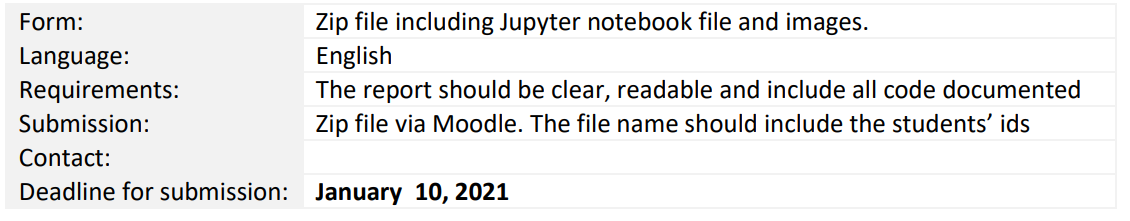

<br>

Students will form teams of two people each, and submit a single homework for each team.   
The same score for the homework will be given to each member of the team.  


Submit your solution in the form of an <a href='https://www.cs.bgu.ac.il/~elhadad/nlp17/notebooks.html'>Jupyter notebook file</a> (with extension ipynb).  
Images of graphs or tables should be submitted as PNG or JPG files.   
The code used to answer the questions should be included, runnable and documented in the notebook. Python 3.6 should be used.


The goal of this homework is to let you understand the details of content based recommender systems and its pros\cons comparing to other recommender system approaches.  
Implementation examples are presented in the Movielens_content_meta and Movielens_content_text notebooks in Moodle.


**Submission:**  
Submission of the homework will be done via Moodle by uploading a zip file containing a
Jupyter notbook and images.  
The deadline for submission of Homework 1 is set to January 10, 2021 end of day Israel.  
The homework needs to be entirely in English.   


We will use the same dataset we used for exercise #1 <a href='https://grouplens.org/datasets/movielens/100k/'>MovieLens 100K rating dataset</a> .   
Split your dataset to train and test.    
You can use the built-in splits included in the dataset.

<br><br><br><br>


## Following is bootstramp based on Asi Notebook

<br><br>

In [409]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt 
import operator
import math

In [293]:
#Binary option should be set to True if the rating should be binary. 
#It should be set to True for the first approach and False for the second approach
BINARY_OPTION = True
#NEGATIVE WEIGHT is relevant only for the first approach
NEGATIVE_WEIGHT = 0.25

In [294]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
folder = "ml-100k/"
ratings = pd.read_csv(folder+'ua.base',sep='\t',names=column_names) 
# sep cannot infer '\t' from files so explicitly supply arg
ratings.head()

user_id  item_id  rating  timestamp
0        1        1       5  874965758
1        1        2       3  876893171
2        1        3       4  878542960
3        1        4       3  876893119
4        1        5       3  889751712

In [295]:
def brating(row):
    if row['rating'] >= 3:
        val = 1
    elif row['rating'] >=0:
        val = -NEGATIVE_WEIGHT
    else:
        val = row['rating']
    return val


ratings['binary_rating'] = ratings.apply(brating, axis=1)
ratings.head()

user_id  item_id  rating  timestamp  binary_rating
0        1        1       5  874965758            1.0
1        1        2       3  876893171            1.0
2        1        3       4  878542960            1.0
3        1        4       3  876893119            1.0
4        1        5       3  889751712            1.0

In [296]:
item_col = ['item_id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
movie_titles = pd.read_csv(folder+"u.item",sep='|',encoding='ISO-8859-1',names=item_col)
movie_titles.head()

item_id        movie title release date  video release date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...        0          0       0        0   
1          1          0         0  ...        0          0       0        0   
2          0          0         0  ...        0          0       0        0   
3          0          0         0  ...        0          0       0        0   
4          0          0         0  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         0    0        0  
4        0        0       0         1    0        0  

[5 rows x 24 columns]

In [297]:
movie_profile = movie_titles[['item_id','Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']].set_index('item_id')
movie_profile.sort_index(axis=0, inplace=True)
movie_profile.head()

Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
item_id                                                                       
1             0          0          1         1       1      0            0   
2             1          1          0         0       0      0            0   
3             0          0          0         0       0      0            0   
4             1          0          0         0       1      0            0   
5             0          0          0         0       0      1            0   

         Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
item_id                                                                         
1            0        0          0       0        0        0        0       0   
2            0        0          0       0        0        0        0       0   
3            0        0          0       0        0        0        0       0   
4            1        0          0       0        0        0        0       0   
5            1        0          0       0        0        0        0       0   

         Thriller  War  Western  
item_id                          
1               0    0        0  
2               1    0        0  
3               1    0        0  
4               0    0        0  
5               1    0        0

In [298]:
if BINARY_OPTION:
    rating_column = 'binary_rating'
else:
    rating_column = 'rating'


In [299]:
user_x_movie = pd.pivot_table(ratings, values=rating_column, index=['item_id'], columns = ['user_id'])
user_x_movie.sort_index(axis=0, inplace=True)
userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movie_profile.columns)
user_x_movie.columns
user_x_movie.iloc[:,2]

item_id
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
1678   NaN
1679   NaN
1680   NaN
1681   NaN
1682   NaN
Name: 3, Length: 1680, dtype: float64

In [300]:
for i in range(len(user_x_movie.columns)):
  working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
  # working_df.replace(0, np.NaN, inplace=True)    
  #working_df: for each movie the user rated the rating in all positve geners otherwise 0
  #user_profile: average rating for all rated movies
  user_profile.loc[userIDs[i]] = working_df.mean(axis=0)


In [301]:
user_profile.head()

Action  Adventure  Animation  Children    Comedy     Crime  Documentary  \
1  0.184160   0.080153   0.027672  0.019084  0.240458  0.071565     0.019084   
2  0.134615   0.038462   0.019231  0.057692  0.206731  0.129808     0.000000   
3  0.119318   0.068182   0.000000  0.000000  0.090909  0.125000     0.022727   
4  0.339286   0.125000   0.000000  0.000000  0.142857  0.214286     0.071429   
5  0.209091   0.134848   0.071212  0.080303  0.253030  0.040909     0.000000   

      Drama   Fantasy  Film-Noir    Horror   Musical   Mystery   Romance  \
1  0.330153  0.007634   0.003817  0.040076  0.026718  0.014313  0.128817   
2  0.548077  0.019231   0.038462  0.038462  0.019231  0.057692  0.269231   
3  0.261364  0.000000   0.017045  0.034091 -0.011364  0.119318  0.062500   
4  0.214286  0.000000   0.000000  0.000000  0.071429  0.214286  0.071429   
5  0.075758  0.004545   0.006061  0.060606  0.065152  0.010606  0.031818   

     Sci-Fi  Thriller       War   Western  
1  0.131679  0.148855  0.081107  0.022901  
2  0.057692  0.187500  0.014423  0.000000  
3  0.073864  0.142045  0.062500  0.000000  
4  0.125000  0.339286  0.071429  0.000000  
5  0.146970  0.066667  0.056061  0.004545

In [302]:
# TFIDF

df = movie_profile.sum()
idf = (len(movie_titles)/df).apply(np.log) #log inverse of DF
TFIDF = movie_profile.mul(idf.values)
TFIDF

Action  Adventure  Animation  Children   Comedy     Crime  \
item_id                                                                
1        0.000000   0.000000   3.690069  2.623718  1.20318  0.000000   
2        1.902286   2.522464   0.000000  0.000000  0.00000  0.000000   
3        0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
4        1.902286   0.000000   0.000000  0.000000  1.20318  0.000000   
5        0.000000   0.000000   0.000000  0.000000  0.00000  2.736391   
...           ...        ...        ...       ...      ...       ...   
1678     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1679     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1680     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1681     0.000000   0.000000   0.000000  0.000000  1.20318  0.000000   
1682     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   

         Documentary     Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  \
item_id                                                                        
1                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
2                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
3                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
4                0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
5                0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
...              ...       ...      ...        ...     ...      ...      ...   
1678             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
1679             0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
1680             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
1681             0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
1682             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   

          Romance  Sci-Fi  Thriller  War  Western  
item_id                                            
1        0.000000     0.0  0.000000  0.0      0.0  
2        0.000000     0.0  1.902286  0.0      0.0  
3        0.000000     0.0  1.902286  0.0      0.0  
4        0.000000     0.0  0.000000  0.0      0.0  
5        0.000000     0.0  1.902286  0.0      0.0  
...           ...     ...       ...  ...      ...  
1678     0.000000     0.0  0.000000  0.0      0.0  
1679     1.918351     0.0  1.902286  0.0      0.0  
1680     1.918351     0.0  0.000000  0.0      0.0  
1681     0.000000     0.0  0.000000  0.0      0.0  
1682     0.000000     0.0  0.000000  0.0      0.0  

[1682 rows x 18 columns]

In [318]:
cosine_similarity_user_item =cosine_similarity(user_profile,TFIDF)
cosine_similarity_user_item

Action  Adventure  Animation  Children   Comedy     Crime  \
item_id                                                                
1        0.000000   0.000000   3.690069  2.623718  1.20318  0.000000   
2        1.902286   2.522464   0.000000  0.000000  0.00000  0.000000   
3        0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
4        1.902286   0.000000   0.000000  0.000000  1.20318  0.000000   
5        0.000000   0.000000   0.000000  0.000000  0.00000  2.736391   
...           ...        ...        ...       ...      ...       ...   
1678     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1679     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1680     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   
1681     0.000000   0.000000   0.000000  0.000000  1.20318  0.000000   
1682     0.000000   0.000000   0.000000  0.000000  0.00000  0.000000   

         Documentary     Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  \
item_id                                                                        
1                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
2                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
3                0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
4                0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
5                0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
...              ...       ...      ...        ...     ...      ...      ...   
1678             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
1679             0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
1680             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   
1681             0.0  0.000000      0.0        0.0     0.0      0.0      0.0   
1682             0.0  0.841567      0.0        0.0     0.0      0.0      0.0   

          Romance  Sci-Fi  Thriller  War  Western  
item_id                                            
1        0.000000     0.0  0.000000  0.0      0.0  
2        0.000000     0.0  1.902286  0.0      0.0  
3        0.000000     0.0  1.902286  0.0      0.0  
4        0.000000     0.0  0.000000  0.0      0.0  
5        0.000000     0.0  1.902286  0.0      0.0  
...           ...     ...       ...  ...      ...  
1678     0.000000     0.0  0.000000  0.0      0.0  
1679     1.918351     0.0  1.902286  0.0      0.0  
1680     1.918351     0.0  0.000000  0.0      0.0  
1681     0.000000     0.0  0.000000  0.0      0.0  
1682     0.000000     0.0  0.000000  0.0      0.0  

[1682 rows x 18 columns]

In [304]:
user_profile

Action  Adventure  Animation  Children    Comedy     Crime  \
1    0.184160   0.080153   0.027672  0.019084  0.240458  0.071565   
2    0.134615   0.038462   0.019231  0.057692  0.206731  0.129808   
3    0.119318   0.068182   0.000000  0.000000  0.090909  0.125000   
4    0.339286   0.125000   0.000000  0.000000  0.142857  0.214286   
5    0.209091   0.134848   0.071212  0.080303  0.253030  0.040909   
..        ...        ...        ...       ...       ...       ...   
939  0.314103   0.134615   0.000000  0.000000  0.256410  0.076923   
940  0.162371   0.061856   0.020619  0.051546  0.311856  0.072165   
941  0.291667   0.041667   0.166667  0.083333  0.416667  0.083333   
942  0.231884   0.144928   0.057971  0.144928  0.257246  0.000000   
943  0.299051   0.142405   0.012658  0.033228  0.139241  0.083861   

     Documentary     Drama   Fantasy  Film-Noir    Horror   Musical   Mystery  \
1       0.019084  0.330153  0.007634   0.003817  0.040076  0.026718  0.014313   
2       0.000000  0.548077  0.019231   0.038462  0.038462  0.019231  0.057692   
3       0.022727  0.261364  0.000000   0.017045  0.034091 -0.011364  0.119318   
4       0.071429  0.214286  0.000000   0.000000  0.000000  0.071429  0.214286   
5       0.000000  0.075758  0.004545   0.006061  0.060606  0.065152  0.010606   
..           ...       ...       ...        ...       ...       ...       ...   
939     0.000000  0.384615  0.025641   0.000000  0.025641  0.000000  0.025641   
940     0.000000  0.371134  0.000000   0.030928  0.028351  0.036082  0.030928   
941     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
942     0.000000  0.405797  0.014493   0.014493  0.028986  0.072464  0.130435   
943     0.000000  0.264241  0.004747   0.000000  0.064873  0.011076  0.012658   

      Romance    Sci-Fi  Thriller       War   Western  
1    0.128817  0.131679  0.148855  0.081107  0.022901  
2    0.269231  0.057692  0.187500  0.014423  0.000000  
3    0.062500  0.073864  0.142045  0.062500  0.000000  
4    0.071429  0.125000  0.339286  0.071429  0.000000  
5    0.031818  0.146970  0.066667  0.056061  0.004545  
..        ...       ...       ...       ...       ...  
939  0.230769  0.128205  0.230769  0.051282  0.000000  
940  0.167526  0.105670  0.134021  0.105670  0.000000  
941  0.000000  0.125000  0.312500  0.000000  0.000000  
942  0.231884  0.072464  0.246377  0.144928  0.043478  
943  0.115506  0.091772  0.177215  0.071203  0.020570  

[943 rows x 18 columns]

In [305]:
def predict_most_similar_items_per_user(user_id,num_items=10):
    result = np.argsort(cosine_similarity_user_item[user_profile.index.get_loc(user_id),:])[::-1][:num_items]
    ret_result = [movie_profile.index[i] for i in result]
    return ret_result

a = predict_most_similar_items_per_user(8)
a.sort()
a

[28, 54, 244, 917, 1025, 1491, 1556, 1559, 1613, 1646]

In [306]:
predict_most_similar_items_per_user(2)


[1682, 1276, 387, 1255, 1256, 1257, 1260, 1261, 1263, 1264]

In [307]:
user_profile.iloc[2,]

Action         0.119318
Adventure      0.068182
Animation      0.000000
Children       0.000000
Comedy         0.090909
Crime          0.125000
Documentary    0.022727
Drama          0.261364
Fantasy        0.000000
Film-Noir      0.017045
Horror         0.034091
Musical       -0.011364
Mystery        0.119318
Romance        0.062500
Sci-Fi         0.073864
Thriller       0.142045
War            0.062500
Western        0.000000
Name: 3, dtype: float64

In [308]:
TFIDF.iloc[1276]

Action         1.902286
Adventure      0.000000
Animation      0.000000
Children       0.000000
Comedy         0.000000
Crime          2.736391
Documentary    0.000000
Drama          0.000000
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.000000
Sci-Fi         0.000000
Thriller       0.000000
War            0.000000
Western        0.000000
Name: 1277, dtype: float64

In [309]:
def data_into_R(name):
    data= pd.read_csv(folder+name, delim_whitespace=True, header=None)
    R = {}
    for i in range(len(data)):
        R[(data.loc[i][0], data.loc[i][1])] = data.loc[i][2]
    return R

## Question 1: Item Similarity (40 points)

<br><br>

*a. Build a movie profile vector based on the item features of your choice. Suggested options: item genres, item title.*

I'll use the movie profile vector that appears above. 
The selected words/features I chose are the following:

In [317]:
print(movie_profile.columns)
movie_profile.head()

Index(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


58

*b. Build a function which provides the 5 most similar items to a specific item. Item to item similarity is calculated using the cosine similarity metric.*

In [311]:
movie_similarities = cosine_similarity(movie_profile, movie_profile)

In [312]:
def n_most_similar_movies(item_id, n = 5):
#   Starting from one to drop the identity item
    result = np.argsort(movie_similarities[item_id,:])[::-1][1:n + 1]
    return result


*c. Use the above function to find most similar items for 2 items from the dataset. Explain your results.*

In [155]:
terminator_id = 195
star_wars = 181
terminator_most_similar = n_most_similar_movies(terminator_id - 1,10)
star_wars_most_similar = n_most_similar_movies(star_wars - 1,10)
print('terminator most simiar: ')
for i in terminator_most_similar:
    print(movie_titles.iloc[i]['movie title'])

print('=======')    
print('start wars most simiar: ')
for i in star_wars_most_similar:
    print(movie_titles.iloc[i]['movie title'])



terminator most simiar: 
Arrival, The (1996)
Solo (1996)
Terminator, The (1984)
Lost in Space (1998)
Lawnmower Man, The (1992)
Face/Off (1997)
Johnny Mnemonic (1995)
Terminator 2: Judgment Day (1991)
Abyss, The (1989)
Escape from L.A. (1996)
start wars most simiar: 
Return of the Jedi (1983)
Empire Strikes Back, The (1980)
Starship Troopers (1997)
African Queen, The (1951)
Last of the Mohicans, The (1992)
Time Tracers (1995)
Star Trek: The Wrath of Khan (1982)
Star Trek III: The Search for Spock (1984)
Star Trek IV: The Voyage Home (1986)
Star Trek: First Contact (1996)


I chose two movies: the first terminator, and starwars
When looking into the movie generes, the labeling of genres is identical or almost identical. 
This is not suprising since this is pretty much what cosines distance does. 
It also appears that the sequels of these movies have similar features since they are among the list of similar movies 


*d. Use the matrix factorization item representation you built in exercise 1 to find the most similar items for the same 2 items you used above. Compare between the results.*

I answered this question bellow together with the MRR comparison. 
plz search 
###### ONE D

<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Content based recommendation (60 points)

<br><br>

*a. Build a function which recommends 5 most relevant items to a user.*


I will use Asi implemnation to predict the 5 most relevant items to a user.
The implemenation is using consine similarity between the TIDF and the user profile 

In [ ]:
def predict_most_similar_items_per_user(user_id,num_items=10):
    result = np.argsort(cosine_similarity_user_item[user_profile.index.get_loc(user_id),:])[::-1][:num_items]
    ret_result = [movie_profile.index[i] for i in result]
    return ret_result

In [266]:
user_profile

Action  Adventure  Animation  Children    Comedy     Crime  \
1    0.184160   0.080153   0.027672  0.019084  0.240458  0.071565   
2    0.134615   0.038462   0.019231  0.057692  0.206731  0.129808   
3    0.119318   0.068182   0.000000  0.000000  0.090909  0.125000   
4    0.339286   0.125000   0.000000  0.000000  0.142857  0.214286   
5    0.209091   0.134848   0.071212  0.080303  0.253030  0.040909   
..        ...        ...        ...       ...       ...       ...   
939  0.314103   0.134615   0.000000  0.000000  0.256410  0.076923   
940  0.162371   0.061856   0.020619  0.051546  0.311856  0.072165   
941  0.291667   0.041667   0.166667  0.083333  0.416667  0.083333   
942  0.231884   0.144928   0.057971  0.144928  0.257246  0.000000   
943  0.299051   0.142405   0.012658  0.033228  0.139241  0.083861   

     Documentary     Drama   Fantasy  Film-Noir    Horror   Musical   Mystery  \
1       0.019084  0.330153  0.007634   0.003817  0.040076  0.026718  0.014313   
2       0.000000  0.548077  0.019231   0.038462  0.038462  0.019231  0.057692   
3       0.022727  0.261364  0.000000   0.017045  0.034091 -0.011364  0.119318   
4       0.071429  0.214286  0.000000   0.000000  0.000000  0.071429  0.214286   
5       0.000000  0.075758  0.004545   0.006061  0.060606  0.065152  0.010606   
..           ...       ...       ...        ...       ...       ...       ...   
939     0.000000  0.384615  0.025641   0.000000  0.025641  0.000000  0.025641   
940     0.000000  0.371134  0.000000   0.030928  0.028351  0.036082  0.030928   
941     0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
942     0.000000  0.405797  0.014493   0.014493  0.028986  0.072464  0.130435   
943     0.000000  0.264241  0.004747   0.000000  0.064873  0.011076  0.012658   

      Romance    Sci-Fi  Thriller       War   Western  
1    0.128817  0.131679  0.148855  0.081107  0.022901  
2    0.269231  0.057692  0.187500  0.014423  0.000000  
3    0.062500  0.073864  0.142045  0.062500  0.000000  
4    0.071429  0.125000  0.339286  0.071429  0.000000  
5    0.031818  0.146970  0.066667  0.056061  0.004545  
..        ...       ...       ...       ...       ...  
939  0.230769  0.128205  0.230769  0.051282  0.000000  
940  0.167526  0.105670  0.134021  0.105670  0.000000  
941  0.000000  0.125000  0.312500  0.000000  0.000000  
942  0.231884  0.072464  0.246377  0.144928  0.043478  
943  0.115506  0.091772  0.177215  0.071203  0.020570  

[943 rows x 18 columns]

*b. Test your recommender system on 2 users. Explain your results.*


Lets look into users who we recommended the terminator and find out why

In [254]:
movies_x_users = pd.pivot_table(ratings, values=rating_column, index=['user_id'], columns = ['item_id'])
movies_x_users.sort_index(axis=0, inplace=True)

users_who_liked_terminator = set()
for i in range(600):
    rec = predict_most_similar_items_per_user(i + 1)
    for j in rec:
        title = movie_titles.iloc[j-1]['movie title']
        if 'terminator' in str(title).lower():
            print(movie_titles.iloc[j-1]['movie title'], movie_titles.iloc[j-1]['item_id'])
            users_who_liked_terminator.add(i + 1)
            pass

print(users_who_liked_terminator)


Terminator 2: Judgment Day (1991) 96
Terminator, The (1984) 195
Terminator 2: Judgment Day (1991) 96
Terminator, The (1984) 195
Terminator 2: Judgment Day (1991) 96
Terminator 2: Judgment Day (1991) 96
Terminator, The (1984) 195
Terminator 2: Judgment Day (1991) 96
Terminator 2: Judgment Day (1991) 96
Terminator, The (1984) 195
{513, 546, 302, 53, 183, 28}


Now lets look at users 513, and 53.
As you can see the prefred genres on these users are exactlty the generes of terminator:
Action, sci-fi and thrillers, which explains well why we recommendade them Terminator.
In addition, user_id 53 even gave high rating to terminator (4, which is above 3, the binary threshold) 

In [255]:
print(user_profile.iloc[512])
print('====')
print(user_profile.iloc[52])

Action         0.750000
Adventure      0.333333
Animation      0.000000
Children       0.000000
Comedy         0.333333
Crime          0.000000
Documentary    0.000000
Drama          0.083333
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.166667
Sci-Fi         0.416667
Thriller       0.333333
War            0.166667
Western        0.083333
Name: 513, dtype: float64
====
Action         0.430556
Adventure      0.222222
Animation      0.000000
Children       0.055556
Comedy         0.152778
Crime          0.111111
Documentary    0.000000
Drama          0.277778
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.083333
Sci-Fi         0.333333
Thriller       0.263889
War            0.111111
Western        0.000000
Name: 53, dtype: float64


In [258]:
ratings[ratings['user_id'] == 53]

user_id  item_id  rating  timestamp  binary_rating
4913       53        7       3  879442991           1.00
4914       53       15       5  879443027           1.00
4915       53       25       4  879442538           1.00
4916       53       50       4  879442978           1.00
4917       53       64       5  879442384           1.00
4918       53       96       4  879442514           1.00
4919       53      118       4  879443253           1.00
4920       53      121       4  879443329           1.00
4921       53      151       4  879443011           1.00
4922       53      156       4  879442561           1.00
4923       53      257       4  879443188           1.00
4924       53      258       4  879442654           1.00
4925       53      284       2  879442901          -0.25
4926       53      546       4  879443329           1.00
4927       53      568       4  879442538           1.00
4928       53      628       5  879443253           1.00
4929       53      748       2  879443329          -0.25
4930       53     1087       4  879443329           1.00

*c. Use the MRR metric to evaluate your recommender system on the test set. Use a cutoff value of 5.*


In [269]:
R = data_into_R('ua.test')


In [288]:
print(R[(1,20)])
ratings[ratings['user_id'] == 1].head(30)

4


user_id  item_id  rating  timestamp  binary_rating
0         1        1       5  874965758           1.00
1         1        2       3  876893171           1.00
2         1        3       4  878542960           1.00
3         1        4       3  876893119           1.00
4         1        5       3  889751712           1.00
5         1        6       5  887431973           1.00
6         1        7       4  875071561           1.00
7         1        8       1  875072484          -0.25
8         1        9       5  878543541           1.00
9         1       10       3  875693118           1.00
10        1       11       2  875072262          -0.25
11        1       12       5  878542960           1.00
12        1       13       5  875071805           1.00
13        1       14       5  874965706           1.00
14        1       15       5  875071608           1.00
15        1       16       5  878543541           1.00
16        1       17       3  875073198           1.00
17        1       18       4  887432020           1.00
18        1       19       5  875071515           1.00
19        1       21       1  878542772          -0.25
20        1       22       4  875072404           1.00
21        1       23       4  875072895           1.00
22        1       24       3  875071713           1.00
23        1       25       4  875071805           1.00
24        1       26       3  875072442           1.00
25        1       27       2  876892946          -0.25
26        1       28       4  875072173           1.00
27        1       29       1  878542869          -0.25
28        1       30       3  878542515           1.00
29        1       31       3  875072144           1.00

In [393]:
def calculate_single_user_MRR(R,user_id):
    recs = predict_most_similar_items_per_user(user_id, 1000)
    filtered_recs = list(filter(lambda x: (user_id, x) in R, a))
    if len(filtered_recs) == 0:
        return None
    MRR_5_len = min(5, len(filtered_recs))
    MRR_5_rating = None
    for i in range(MRR_5_len): 
        if R[(user_id,filtered_recs[i])] >= 3:
            MRR_5_rating = 1 / (i + 1)
            break
    if MRR_5_rating is None:
        MRR_5_rating = 0
    return MRR_5_rating
    


In [394]:
def evaluate_all_users(R):
    MRR_sum = 0
    user_not_participated = 0
    for user_id in range(1, len(user_profile)):
        rating = calculate_single_user_MRR(R, user_id)
        if rating:
            MRR_sum += rating
        else: 
            user_not_participated + 1
#     print
    num_of_users_participated = len(user_profile) - user_not_participated 
    return MRR_sum / num_of_users_participated


Results For MRR over test set ua.test


In [395]:
evaluate_all_users(R)

0.9303464121597739

*d. Compare the results of the content based recommender system to the matrix factorization recommender system using the same train and test set. Use the MRR metric for the comparison.*

For this Question I will copy some code from the previous HW


In [402]:
num_users = len(user_profile)
num_movies = len(movie_profile)
num_movies

1682

In [397]:
def calculate_evaluate_single_user(predictions,R,user_id):
    rated_movies = []
    for j in range(num_movies):
        if (user_id,j) in R:
            rated_movies.append([j,R[(user_id,j)], predictions.loc[user_id,j]])
    
    if not rated_movies:
        return None
    sorted_prediction_movies = sorted(rated_movies, key = lambda x: x[2])
    sorted_prediction_movies.reverse()
    sorted_rated_movies = sorted(rated_movies, key = lambda x: x[1])
    sorted_rated_movies.reverse()
#     print(user_id)
#     print([[sorted_prediction_movies[i][1], sorted_rated_movies[i][1]] for i in range(len(sorted_prediction_movies))])
    MRR_5_len = min(5, len(rated_movies))
    MRR_10_len = min(10, len(rated_movies))
    MRR_5_rating = None
    MRR_10_rating = None
    DCG_5 = 0
    IDCG_5 = 0
    DCG_10 = 0
    IDCG_10 = 0
    for i in range(MRR_10_len): 
        if sorted_prediction_movies[i][1] >= 3 and i < MRR_5_len and MRR_5_rating is None:
            MRR_5_rating = 1 / (i + 1)
        if sorted_prediction_movies[i][1] >= 3 and MRR_10_rating is None:
            MRR_10_rating = 1 / (i + 1)
        
        if i < MRR_5_len:
            DCG_5 += sorted_prediction_movies[i][1] / math.log2(i + 2)
            IDCG_5 += sorted_rated_movies[i][1] / math.log2(i + 2)
        DCG_10 += sorted_prediction_movies[i][1] / math.log2(i + 2)
        IDCG_10 += sorted_rated_movies[i][1] / math.log2(i + 2)
    
    if MRR_5_rating is None:
        MRR_5_rating = 0
    if MRR_10_rating is None: 
        MRR_10_rating = 0
    return {'nDCG_10': DCG_10 / IDCG_10,'nDCG_5': DCG_5 / IDCG_5, 'MRR_5': MRR_5_rating, 'MRR_10': MRR_10_rating }
    



In [396]:
def evaluate_all_users(predictions,R):
    evaluations = {'nDCG_10': 0, 'nDCG_5': 0, 'MRR_5': 0,'MRR_10': 0}
    user_not_participated = 0
    for user_id in range(num_users):
        user_res = calculate_evaluate_single_user(predictions, R, user_id)
#         print(user_res)
        if user_res:
            evaluations['MRR_5'] += user_res['MRR_5']
            evaluations['MRR_10'] += user_res['MRR_10']        
            evaluations['nDCG_5'] += user_res['nDCG_5']
            evaluations['nDCG_10'] += user_res['nDCG_10']
        else: 
            user_not_participated+1
#     print
    num_of_users_participated = num_users - user_not_participated 
    for eval in evaluations.keys():
        evaluations[eval] = evaluations[eval] / num_of_users_participated
    return evaluations



In [398]:
def calculate_rmse(U,V,R): 
    UV_T = U.dot(V.T)
    total = 0
    err = 0
    for i in range(num_users):
        for j in range(num_movies):
            t = (i, j)
            if t in R:
                total+=1
                err += (R[t] - UV_T.loc[i,j]) ** 2
    return math.sqrt(err / total)

In [415]:
def GD(alpha, K, lamnda_regularization, convergence_limit):
    print('alpha: %f, K: %f, lamnda: %f' % (alpha, K, lamnda_regularization) )
    print('alpha: ' + str(alpha) + ' K: ' + str(K) + ' lambda: ' + str(lamnda_regularization))
    results = {'alpha': alpha ,'lamnda_regularization': lamnda_regularization, 'K': K, 'convergence_limit': convergence_limit}
    U = pd.DataFrame(np.random.rand(num_users,K))
    V = pd.DataFrame(np.random.rand(num_movies,K))
    train_name = 'ua.base'
    test_name = 'ua.test'
    R = data_into_R(train_name)
    round = 0
    rmse_errors = []
    error_delta = 200
    previous_rmse = error_delta
    while error_delta > convergence_limit and round < 22:
        UV_T = U.dot(V.T)
        for i in range(1, num_users):
            for q in range(K):
                err_user_component = 0
                for j in range(1, num_movies):
                    if (i,j) in R:
                        e_ij = R[(i,j)] - UV_T.loc[i, j]
                        err_user_component += V.loc[j,q] * e_ij
                U.loc[i,q] += alpha * (err_user_component - lamnda_regularization * U.loc[i,q])
#           I wasn't sure about this part, but it produced slightly better results if I adjusted 
#           the predictions before going to train the items vectors
        UV_T = U.dot(V.T)
        for movie_id in range(1, num_movies):
            for q in range(K): 
                err_movie_component = 0
                for user_id in range(1, num_users):
                    if (user_id,movie_id) in R:
                        e_ij = R[(user_id,movie_id)] - UV_T.loc[user_id, movie_id]
                        err_movie_component += U.loc[user_id,q] * e_ij
                V.loc[movie_id, q] +=  alpha * (err_movie_component - lamnda_regularization * V.loc[movie_id, q])
        current_rmse = calculate_rmse(U,V, R)
        error_delta = abs(previous_rmse - current_rmse)
        previous_rmse = current_rmse
        rmse_errors.append([round, current_rmse])
        print('round: %d RMSE %f, convergence error: %f'% (round ,current_rmse, error_delta))
        round+=1
    R_test = data_into_R(test_name)
    rmse_test_result = calculate_rmse(U,V, R_test)
    print('test RMSE %f'% rmse_test_result)
    predictions = UV_T = U.dot(V.T)
    evaluations = evaluate_all_users(predictions,R_test)
    results = {**evaluations,
               **{'predictions': predictions, 'R_test': R_test, 'U': U, 'V': V}, 
               **{'rmse_test_error': rmse_test_result, 
                  'training_errors': rmse_errors, 
                  'predictions': predictions}}
    return results

In [417]:
alphas = [0.00025]
lamnda_regularizations = [0.002]
Ks = [10]
GDs = []

In [418]:
for k in Ks:
    for re in lamnda_regularizations:
        for a in alphas:
            gd_result = GD(a, k, re, 0.0000002)
            GDs.append(gd_result)
            line= {'alg': 'gradient descent', 
                   'lambda': re,
                   'K': k,
                   'alpha': a,
                   'rmse': gd_result['rmse_test_error'],
                    'nDCG_10': gd_result['nDCG_10'],
                   'MRR_10': gd_result['MRR_10'],
                  'nDCG_5': gd_result['nDCG_5'],
                  'MRR_5': gd_result['MRR_5'],
                  'convergence_limit': 0.02}
            print(line)


alpha: 0.000250, K: 10.000000, lamnda: 0.002000
alpha: 0.00025 K: 10 lambda: 0.002
round: 0 RMSE 1.486182, convergence error: 198.513818
round: 1 RMSE 1.365090, convergence error: 0.121092
round: 2 RMSE 1.277376, convergence error: 0.087714
round: 3 RMSE 1.214271, convergence error: 0.063105
round: 4 RMSE 1.168389, convergence error: 0.045882
round: 5 RMSE 1.134291, convergence error: 0.034098
round: 6 RMSE 1.108257, convergence error: 0.026034
round: 7 RMSE 1.087826, convergence error: 0.020431
round: 8 RMSE 1.071382, convergence error: 0.016444
round: 9 RMSE 1.057850, convergence error: 0.013532
round: 10 RMSE 1.046500, convergence error: 0.011350
round: 11 RMSE 1.036825, convergence error: 0.009675
round: 12 RMSE 1.028464, convergence error: 0.008361
round: 13 RMSE 1.021152, convergence error: 0.007312
round: 14 RMSE 1.014692, convergence error: 0.006460
round: 15 RMSE 1.008935, convergence error: 0.005758
round: 16 RMSE 1.003763, convergence error: 0.005172
round: 17 RMSE 0.999085,

cutoff 5 MRR result of GD content based 

In [419]:
GDs[0]['MRR_5']

0.9548427006009192

So the content base MRR result is: 0.9303464121597739
and the matrix factorization is: 0.9548427006009192
which is slightly better.

##### ONE D

In [428]:
terminator_id = 195
star_wars = 181
terminator_most_similar = n_most_similar_movies(terminator_id - 1,10)
star_wars_most_similar = n_most_similar_movies(star_wars - 1,10)
print('terminator most simiar: ')
for i in terminator_most_similar:
    print(movie_titles.iloc[i]['movie title'])

print('=======')    
print('start wars most simiar: ')
for i in star_wars_most_similar:
    print(movie_titles.iloc[i]['movie title'])


terminator most simiar: 
House Party 3 (1994)
Careful (1992)
Ponette (1996)
In the Line of Fire (1993)
Mirror Has Two Faces, The (1996)
So I Married an Axe Murderer (1993)
E.T. the Extra-Terrestrial (1982)
Cops and Robbersons (1994)
Somewhere in Time (1980)
Just Cause (1995)
start wars most simiar: 
Tokyo Fist (1995)
To Gillian on Her 37th Birthday (1996)
Little Princess, The (1939)
Set It Off (1996)
Billy Madison (1995)
Drunks (1995)
Backbeat (1993)
Heathers (1989)
Mrs. Dalloway (1997)
Dances with Wolves (1990)


In [426]:
movie_similarities_factorization = cosine_similarity(GDs[0]['V'], GDs[0]['V'])

def n_most_similar_movies(item_id, n = 5):
#   Starting from one to drop the identity item
    result = np.argsort(movie_similarities_factorization[item_id - 1,:])[::-1][1:n + 1]
    return result

In [437]:
terminator_most_similar_factorization = n_most_similar_movies(terminator_id,10)
star_wars_most_similar_factorization = n_most_similar_movies(star_wars,10)
print('terminator most simiar: ')
for i in terminator_most_similar_factorization:
    print(movie_titles.iloc[i]['movie title'])

print('=======')    
print('star wars most simiar: ')
for i in star_wars_most_similar_factorization:
    print(movie_titles.iloc[i]['movie title'])

terminator most simiar: 
Hot Shots! Part Deux (1993)
Ed Wood (1994)
Babe (1995)
Shining, The (1980)
Clockwork Orange, A (1971)
Die Hard (1988)
Angels and Insects (1995)
Scream of Stone (Schrei aus Stein) (1991)
Speed (1994)
Victor/Victoria (1982)
star wars most simiar: 
Candyman (1992)
Careful (1992)
U.S. Marshalls (1998)
Mary Reilly (1996)
A Chef in Love (1996)
Roommates (1995)
Conan the Barbarian (1981)
Cyclo (1995)
Cops and Robbersons (1994)
Somewhere in Time (1980)


So it seems like starwarz and terminator prodced more actions / scifi movies, but not even close to the similarity that the content base recommendation produced. At least in the sense the among the first 10 movies we can't find the sequals at all.
This is aligning with the understanding that matrix factorizations are much less explainable and 'obvious' and with movies like thse blockbusters 

*e. Discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems (refer to accuracy, complexity, explainaiblity and new user\new items) and when will you recommend using each approach.*

content based recommendations allows us to embed into the reommendation process a domain understanding. For instance we may engineer the feature extraction and normalization according to some domain expert. This will give an advantage the the final result since it might be the kind of understanding that only after a lot of data can be learnt using any machine learning algorithms. In the vanilla implementation of matrix factorization we don't have such capability (unlike the hybrid model). The matrix factorization is agnostic to the features of the items, and thus loses a lot during the process of model generation (aka the matrix U and V) . 

With content base we are also building an explicity user profile, it means that if a new user is intruduced into our system we may use a simple wizard to generate the user profile (with user interaction). For instance asking him/her for their movie preferences, this means we wont need them to rate anything and we'll be able to generate  recommendation for them.
It is also good for cold start with items, all we need is the items attribute, we dont need any user ratings (unlike matrix factorization) 

In addition to that, once a recommnedation is made it is very clear why was it made: a high fit between the feature of the movie and the user profile: explainability. 

On the other hand, matrix factorization looks at the bigger picture, it uses both the items vectors and the user vectors. 
It require minimal domain knowledge (we dont need features at all, only ratings).
The recommendation model is taking other users rating into consideration when predicting a single item recommendation. 
A lot of times it will produce better results (Just like we saw with the MRR above example). 
Unlike content base recommendation, matrix factorization can recommend suprising items, this happens because the process will recognize similar users and predicts according to their profile . 
The process req

At the end, the recommendations are not so easily expalinable, we cant just take the user vector and understand why did it produce a certain prediction. 




<br><br><br>
<br><br><br>

### Good luck